In [1]:
import os, sys
sys.path.append( os.path.join('..', '..'))

import numpy as np
from scipy.constants import e, k, epsilon_0

# my own modules
from src.solver import Poisson_solver1D as solver1D
from src.solver import updater
from src.model.carrier_density import *
from src.model import density_of_state as DOS
from src.model.position import get_1D_position_mask

# Multiple Quantum Well (Heterojuction + PIN junction)

This is just a simple case without considering quantum effect.

A N type semiconductor with boundary condition <br>
Na : acceptor doping density <br>
Nd : donor doping density <br>
Ec : conduction band edge <br>
Ev : valence band edge <br>
Ef : Fermi level  <br>
n  : electron (carrier) density <br>
p  : hole (carrier) density <br>
Field : electric field <br>
V  : voltage <br>

In [2]:
""" constants setting """
T = 300
kT_q = k*T/e

materials = ['GaN', 'InGaN', 'GaN', 'InGaN', 'GaN', 'InGaN', 'GaN']
x_range = np.array( [ [-np.inf, 0], [0, 0.25e-4], [0.25e-4, 0.5e-4], [0.5e-4, 0.75e-4], [0.75e-4, 1.00e-4], [1.00e-4, 1.25e-4], [1.25e-4, np.inf] ] )

x = np.linspace(-1e-4, 3e-4, 6000) # cm
Na = dope_constant_acceptor(x = x, Nd = 1e16, x_range=x_range[0]) # cm^-3
Nd = dope_constant_donor(x = x, Na = 1e16, x_range=x_range[-1]) # cm^-3
epsilon_q =  epsilon_0 * 1e-2 * get_episolon_r_at_different_x(x = x, materials=materials, x_range=x_range) / e 

In [3]:
""" condition/material """
def cal_Ec_from_V(x, V, q = 1.0):
    Ec = -q*V
    mask = get_1D_position_mask(x, [x_range[1], x_range[3], x_range[5]])
    Ec[mask] += EA['GaN'] - EA['InGaN']
    return Ec
def cal_Ev_from_V(x, V, q = 1.0):
    Ec = cal_Ec_from_V(x, V, q=q)
    return cal_Ev_from_Ec_at_different_x(x = x, Ec = Ec, materials = materials, x_range = x_range)
def cal_n(x, V):
    Ec = cal_Ec_from_V(x, V)
    return cal_electron_density_at_different_x(x = x, Ec = Ec, Ef = 0.0, kT = kT_q, materials = materials, x_range = x_range)
def cal_p(x, V):
    Ev = cal_Ev_from_V(x, V)
    return cal_hole_density_at_different_x(x = x, Ev = Ev, Ef = 0.0, kT = kT_q, materials = materials, x_range = x_range)
def cal_dn_dV(x, V):
    Ec = cal_Ec_from_V(x, V)
    return -cal_dn_dEc_at_different_x(x = x, Ec = Ec, Ef = 0.0, kT = kT_q, materials = materials, x_range = x_range)
def cal_dp_dV(x, V):
    Ev = cal_Ev_from_V(x, V)
    return -cal_dp_dEv_at_different_x(x = x, Ev = Ev, Ef = 0.0, kT = kT_q, materials = materials, x_range = x_range)

def cal_total_charge_density(x, V):
    N  = Nd  - Na  + cal_p(x,  V)  - cal_n(x,  V)
    return N
def cal_dtotal_charge_density_dV(x, V):
    dN_dV  = cal_dp_dV(x,  V)  - cal_dn_dV(x,  V)
    return dN_dV

def src_fun(x, V):
    return to_poisson_source(charge_density = cal_total_charge_density(x, V), epsilon=epsilon_q)
def d_src_dV_fun(x, V):
    return to_poisson_source(charge_density = cal_dtotal_charge_density_dV(x, V), epsilon=epsilon_q)  

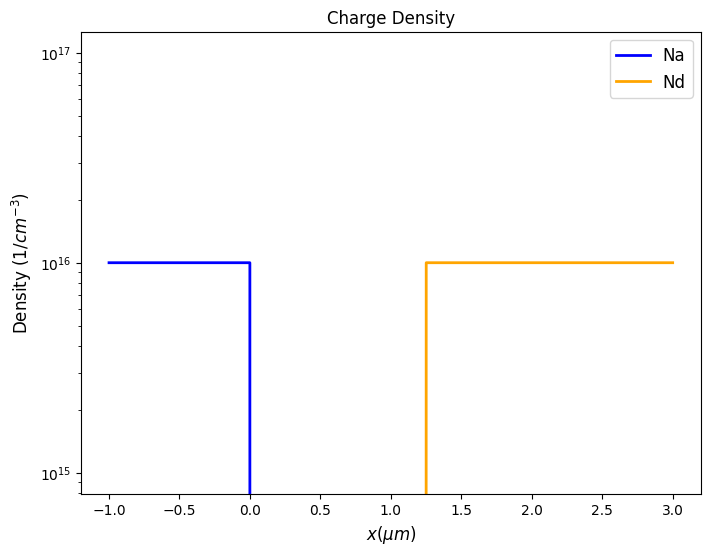

In [4]:
""" plot doping """
solver1D.plot_carrier_density_1D(x, Na = Na, Nd = Nd);

In [5]:
""" solve Poisson equation """
V_updater = updater.AdagradUpdater(size = x.size, lr=0.1)
V = solver1D.solve_Poisson_1D(x = x, max_iter=10000, src_fun = src_fun, dsrc_dV_fun = d_src_dV_fun, V_updater = V_updater)

 68%|██████▊   | 6847/10000 [01:41<00:46, 67.24it/s]


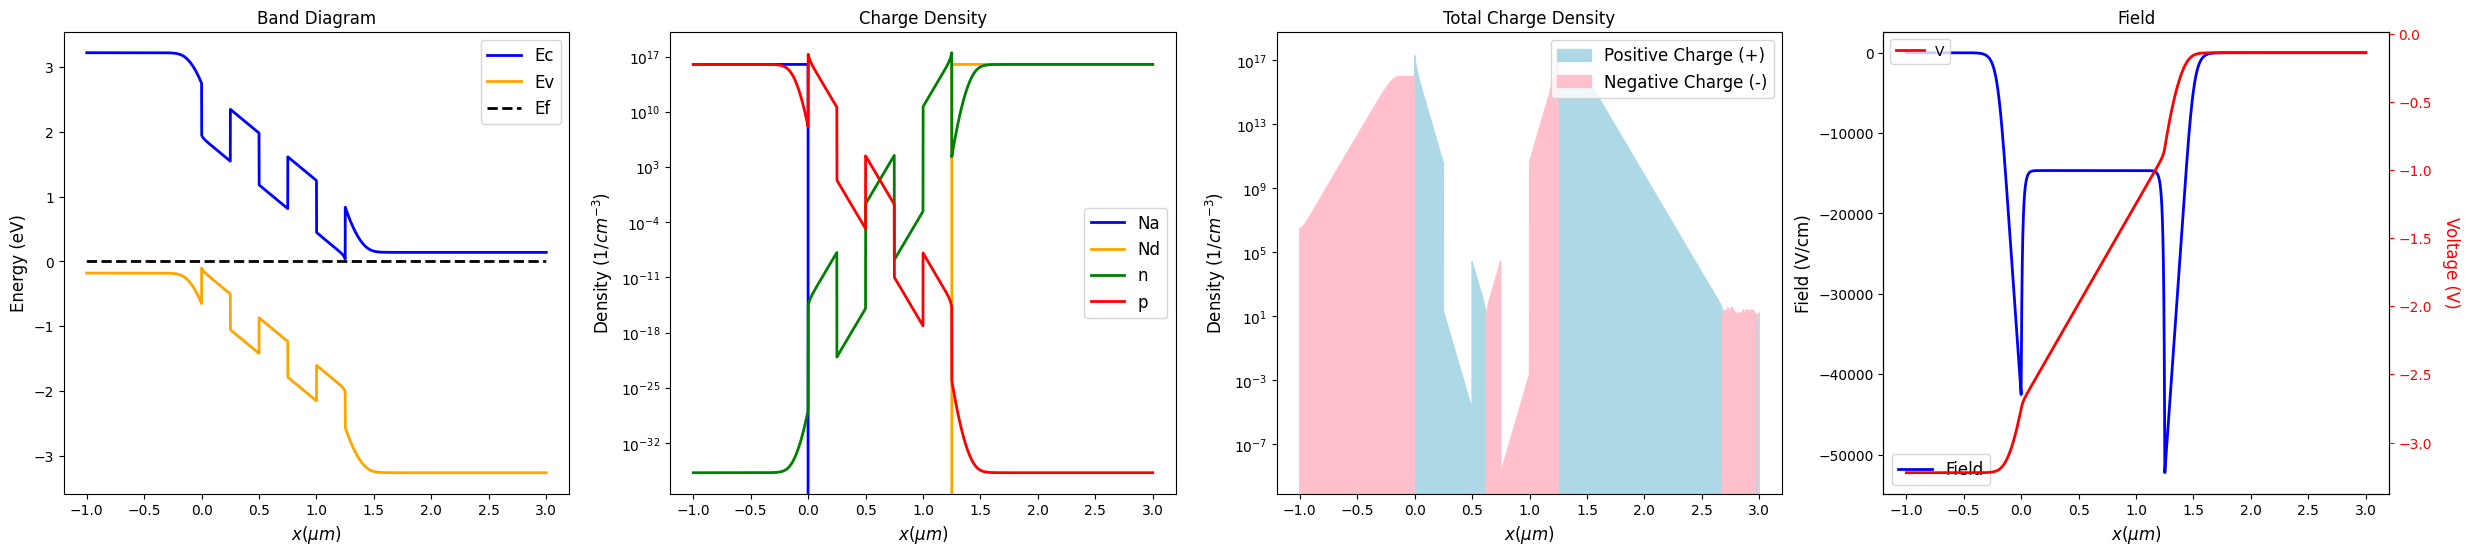

In [6]:
""" plot results """
n = cal_n(x, V)
p = cal_p(x, V)
Ec = cal_Ec_from_V(x, V)
Ev = cal_Ev_from_V(x, V)
total_charge_density = cal_total_charge_density(x, V)
Field = cal_electric_field(x, V)

solver1D.plot_Poisson_1D(x=x, V=V, n=n, p=p, total_charge_density=total_charge_density, Ec=Ec, Ev=Ev, Field=Field, Na=Na, Nd=Nd);